## Breast cancer cell lines

## 0. Loading the libraries

In [64]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [65]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
sb.set_context('notebook')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
plt.rcParams['figure.figsize']=(8,8) #rescale figures
plt.rcParams.update({'figure.max_open_warning': 0})


from gprofiler import gprofiler

#import sys


import scprep
from umap import UMAP
import graphtools as gt
import meld
import magic

In [66]:
import rpy2
print(rpy2.__version__)

3.4.2


In [67]:
# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
import rpy2.robjects as ro

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from rpy2.robjects import numpy2ri
numpy2ri.activate()

import anndata2ri
anndata2ri.activate()

%reload_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

import scvi

-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.1
-----
PIL                 8.3.1
absl                NA
anndata             0.7.6
anndata2ri          0.0.0
attr                21.2.0
autoreload          NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2021.05.30
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
colorama            0.4.4
concurrent          NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
decorator           4.4.2
defusedxml          0.7.1
deprecate           0.3.0
deprecated          1.2.12
dunamai             1.6.0
encodings           NA
fsspec              2021.07.0
future              0.18.2
genericpath         NA
get_version         3.5
google              NA
gprofiler           1.0.0
graphtools          1.5.2
h5py                3.3.0
idna                3.2
igraph              0.9.6
ipykernel           6.1.0
ipython_genutils  

In [68]:
%%R
.libPaths(R.home("~/anaconda3/envs/scvi-env-2022/lib/R/library"))
library(SingleCellExperiment)
#library(here)
#install.packages("stringr")
library(stringr)
REFINED <- "/home/data/refined/sc-bc-cell-lines/1-alevin-fry/expr_matrices"

<a id="Reading"></a>

## 1. Reading in the data

Here we are loading the gene x cell count matrix after cell filtering using emptyDrops (exp02-emptyDrops_sceQC)

In [73]:
%%R -o bccl
adata = readRDS(file.path(REFINED, "5_final_sce.rds"))
print(adata)
colData(adata)[1:10]
adata$sample_name <- adata$seq_folder
bccl <- adata[, colData(adata)$study_id %in% c("BC-Cell-Lines", "Both")]
bccl

class: SingleCellExperiment 
dim: 19728 48247 
metadata(0):
assays(2): counts logcounts
rownames(19728): AP006222.2 AL732372.1 ... AC007325.4 AC007325.2
rowData names(0):
colnames(48247): BT20_TGTTGTAACACA BT20_TTATCATTCGAA ...
  ZR75_ATGGGTTAACCT ZR75_GTCGGGTATATA
colData names(35): seq_folder nUMI ... nFeature_RNA ident
reducedDimNames(0):
altExpNames(0):
class: SingleCellExperiment 
dim: 19728 35325 
metadata(0):
assays(2): X logcounts
rownames(19728): AP006222.2 AL732372.1 ... AC007325.4 AC007325.2
rowData names(0):
colnames(35325): BT20_TGTTGTAACACA BT20_TTATCATTCGAA ...
  ZR75_ATGGGTTAACCT ZR75_GTCGGGTATATA
colData names(35): seq_folder nUMI ... nFeature_RNA ident
reducedDimNames(0):
altExpNames(0):


Now switch to python


In [133]:
adata=bccl.copy()


In [134]:
# Annotate the data sets
print(adata.obs['sample_name'].value_counts())

MDAMB231          6886
BT20              6081
MDAMB436          5509
HCC70             4675
T47D              3315
ZR75              3143
SKBR3             1782
MCF7-ATCC-DMEM    1491
MCF7-ATCC-RPMI    1453
MCF7-LAB-RPMI      537
MCF7-LAB-EMEM      453
Name: sample_name, dtype: int64


In [135]:
# Checking the total size of the data set
adata.shape

(35325, 19728)

## 2. Filtering genes

<a id="QC"></a>

In [136]:
adata.X

<35325x19728 sparse matrix of type '<class 'numpy.float32'>'
	with 36817372 stored elements in Compressed Sparse Row format>

In [137]:
adata.obs['nCount_RNA']

BT20_TGTTGTAACACA    9163.0
BT20_TTATCATTCGAA    8528.0
BT20_CTATGACGCCTG    9580.0
BT20_CGAGCTTGCAGG    7301.0
BT20_CACGATTCAAAC    8582.0
                      ...  
ZR75_GTTGACGCACGG    1922.0
ZR75_AAACCGTTGACC    1382.0
ZR75_GGCGCCGTTCTC    1809.0
ZR75_ATGGGTTAACCT    1509.0
ZR75_GTCGGGTATATA    1713.0
Name: nCount_RNA, Length: 35325, dtype: float64

In [138]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.X.sum(1))
adata.obs['n_genes'] = (adata.X > 0).sum(1)

adata.obs['seq_folder']
adata.obs['orig.ident'] = adata.obs['seq_folder']


In [139]:
print(min(adata.obs['n_counts']))
print(min(adata.obs['n_genes']))

498.0
398


/home/hallett/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'seq_folder' as categorical
/home/hallett/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'quant_code' as categorical
/home/hallett/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecat

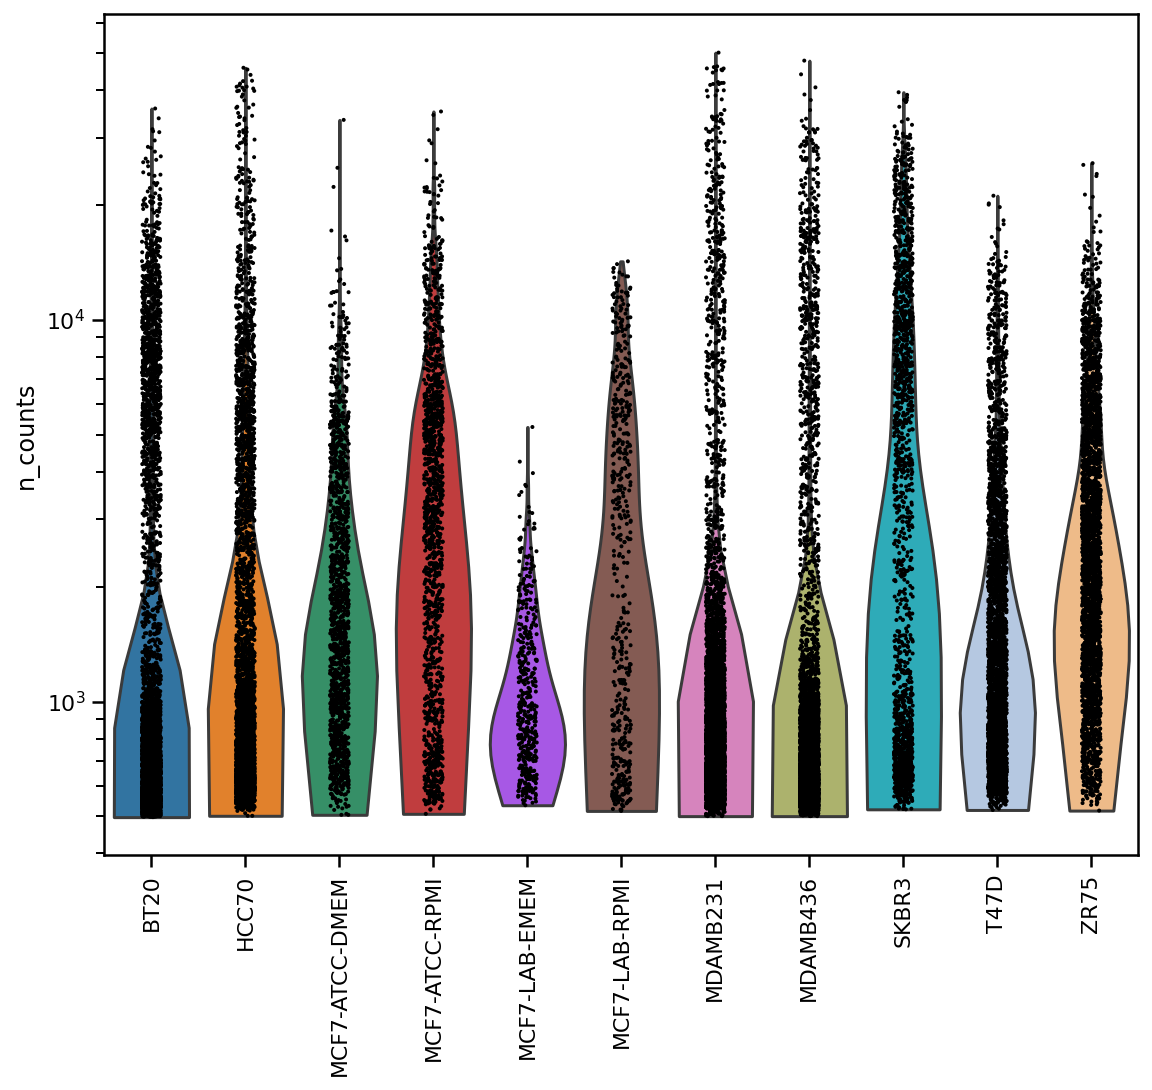

In [140]:
t1 = sc.pl.violin(adata, 'n_counts', groupby='orig.ident', size=2, rotation = 90, log=True, cut=0,save="raw_counts.png")

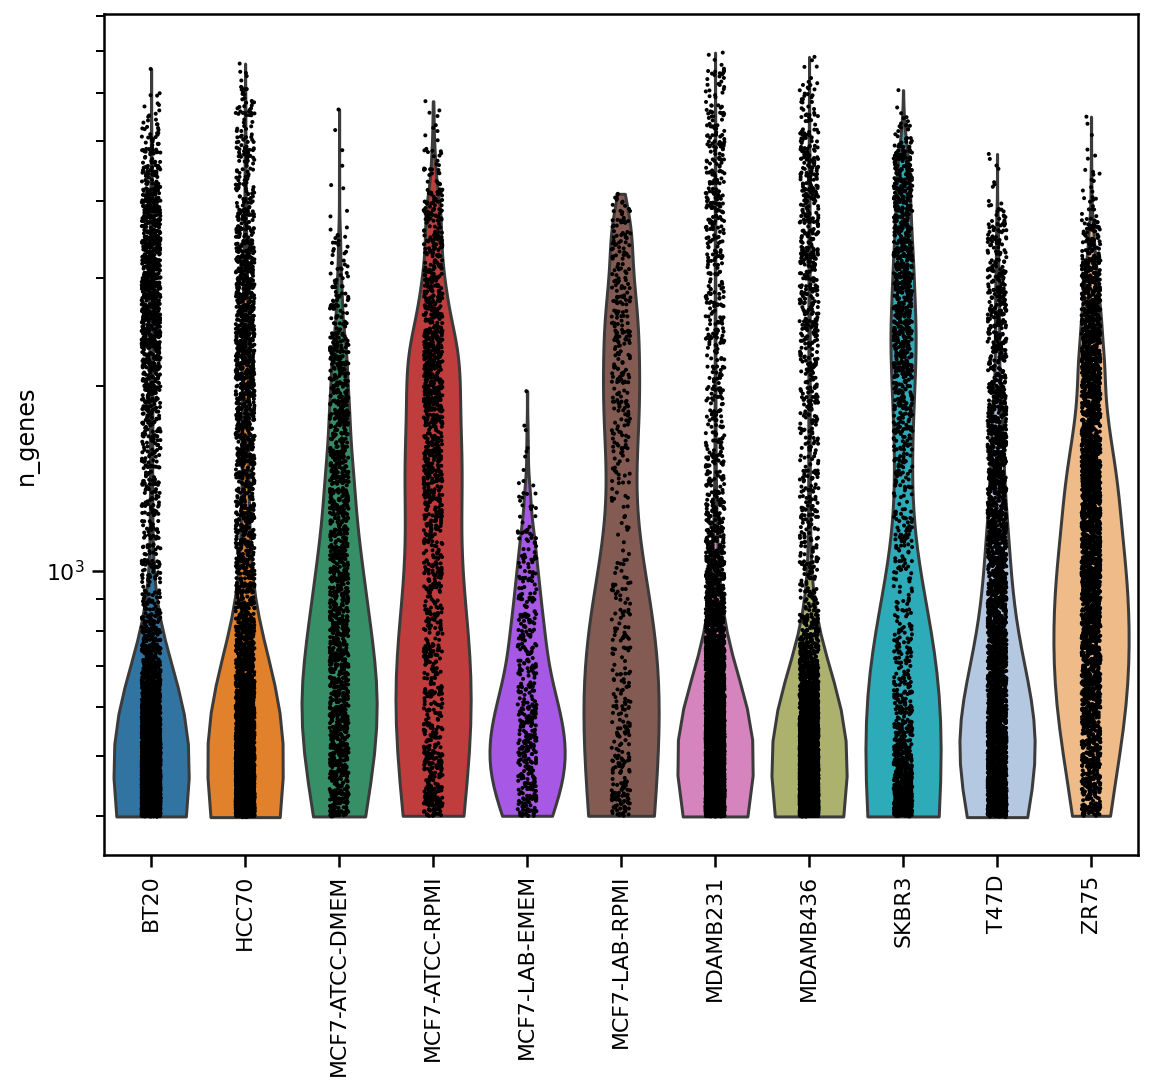

In [141]:
t1 = sc.pl.violin(adata, 'n_genes', groupby='orig.ident', size=2, rotation = 90, log=True, cut=0,save="raw_genes.png")

In [142]:
orig_adata = adata.copy() 

# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 800)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 5000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

#adata = adata[adata.obs['subsets_Ribo_percent'] < 0.70]
#print('Number of cells after ribo filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 400)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))


Total number of cells: 35325
filtered out 16685 cells that have less than 800 counts
Number of cells after min count filter: 18640
filtered out 5037 cells that have more than 5000 counts
Number of cells after max count filter: 13603
Number of cells after gene filter: 13603


In [143]:
# Annotate the data sets
print(adata.obs['orig.ident'].value_counts())


MDAMB231          2496
ZR75              2193
T47D              2028
HCC70             1643
MDAMB436          1273
BT20              1131
MCF7-ATCC-DMEM    1045
MCF7-ATCC-RPMI     742
SKBR3              512
MCF7-LAB-EMEM      300
MCF7-LAB-RPMI      240
Name: orig.ident, dtype: int64


In [144]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after gene filter: {:d}'.format(adata.n_vars))

Total number of genes: 19728
filtered out 5257 genes that are detected in less than 20 cells
Number of genes after gene filter: 14471


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

In [146]:
adata.obs.head()

,seq_folder,nUMI,nGene,quant_code,suid,code2,sample_name,study_id,index_number,batch_number,...,mitoRatio,cells,sample,nCount_RNA,nFeature_RNA,ident,n_counts,log_counts,n_genes,orig.ident
BT20_ACGCGGGGCTCG,BT20,4898.0,2007,BT20_DSP992,1,BT20_1_DSP992,BT20,BC-Cell-Lines,N701,DSP992,...,0.026541,BT20_ACGCGGGGCTCG,BT20,4897.0,2006,BT20,4897.0,8.496378,2006,BT20
BT20_CAAATAGTTACG,BT20,4637.0,2310,BT20_DSP992,1,BT20_1_DSP992,BT20,BC-Cell-Lines,N701,DSP992,...,0.024801,BT20_CAAATAGTTACG,BT20,4637.0,2310,BT20,4637.0,8.441823,2310,BT20
BT20_GCTTAGGAGGCC,BT20,4911.0,2258,BT20_DSP992,1,BT20_1_DSP992,BT20,BC-Cell-Lines,N701,DSP992,...,0.020566,BT20_GCTTAGGAGGCC,BT20,4911.0,2258,BT20,4911.0,8.499233,2258,BT20
BT20_CCGTCATGAATT,BT20,952.0,639,BT20_DSP992,1,BT20_1_DSP992,BT20,BC-Cell-Lines,N701,DSP992,...,0.016807,BT20_CCGTCATGAATT,BT20,952.0,639,BT20,952.0,6.858565,639,BT20
BT20_CAAACGTGGCCG,BT20,939.0,644,BT20_DSP992,1,BT20_1_DSP992,BT20,BC-Cell-Lines,N701,DSP992,...,0.014909,BT20_CAAACGTGGCCG,BT20,939.0,644,BT20,939.0,6.844815,644,BT20


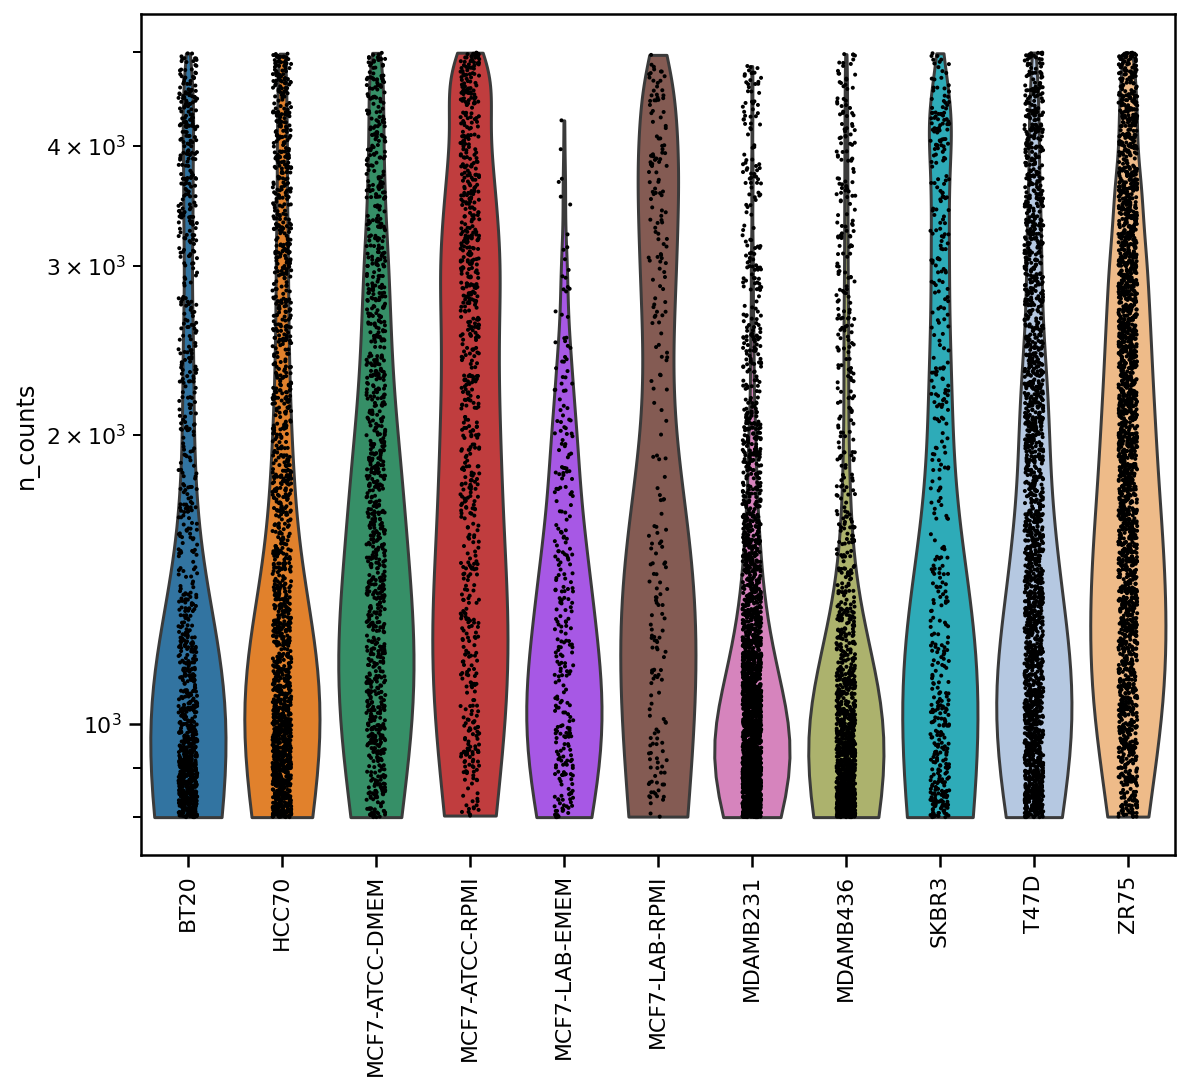

In [147]:
t1 = sc.pl.violin(adata, 'n_counts', groupby='orig.ident', size=2, rotation = 90, log=True, cut=0)

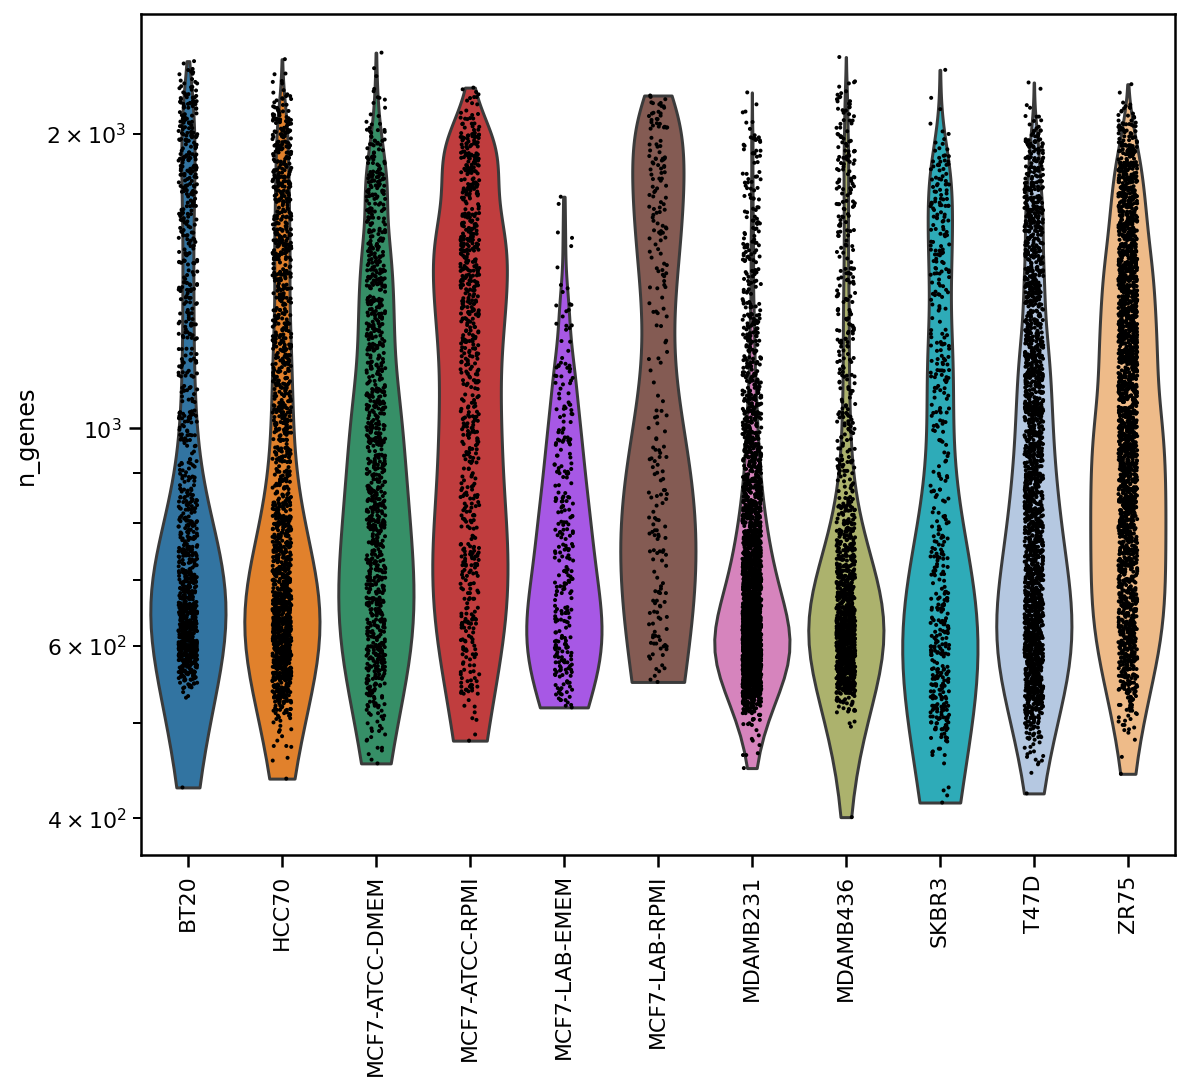

In [149]:
t1 = sc.pl.violin(adata, 'n_genes', groupby='orig.ident', size=2, rotation = 90, log=True, cut=0)

## 3. Save anndata

In [156]:
REFINED = "/home/data/refined/sc-bc-cell-lines/1-alevin-fry/expr_matrices/"
#del adata.obs['suid']
#del adata.obs['nFeature_RNA']
#del adata.obs['cm_cells']
#del adata.obs['cm_genes']

adata.obs['raw_cells'] = adata.obs['raw_cells'].astype(float)
adata.obs['nFeature_RNA'] = adata.obs['nFeature_RNA'].astype(float)
adata.obs['nGene'] = adata.obs['nGene'].astype(float)
adata.obs['cm_cells'] = adata.obs['cm_cells'].astype(float)
adata.obs['cm_genes'] = adata.obs['cm_genes'].astype(float)

adata.obs['raw_genes'] = adata.obs['raw_genes'].astype(float)
adata.obs['num_1k'] = adata.obs['num_1k'].astype(float)
adata.obs['merge_targets'] = adata.obs['merge_targets'].astype(float)

print(adata.obs['num_1k'])
#del adata.obs['merge_targets']
#del adata.obs['sample_number']
#del adata.obs['batch_number']
#del adata.obs['index']
#del adata.obs['nGene']

#adata.obs['nGene']=adata.obs['nGene'].astype(int)
#adata.obs["nFeature_RNA"] = adata.obs["nFeature_RNA"].astype(int)
adata.write(REFINED+'6-final_scvi_ready_sce.h5ad')
#adata.write('/home/data/refined/sc-bc-cell-lines/1-alevin-fry/finalall-adata.h5ad')

BT20_ACGCGGGGCTCG    1488.0
BT20_CAAATAGTTACG    1488.0
BT20_GCTTAGGAGGCC    1488.0
BT20_CCGTCATGAATT    1488.0
BT20_CAAACGTGGCCG    1488.0
                      ...  
ZR75_GTTGACGCACGG    1907.0
ZR75_AAACCGTTGACC    1907.0
ZR75_GGCGCCGTTCTC    1907.0
ZR75_ATGGGTTAACCT    1907.0
ZR75_GTCGGGTATATA    1907.0
Name: num_1k, Length: 13603, dtype: float64


In [157]:
adata.obs.to_csv(REFINED+'6-final_scvi_ready_sce.csv')
t=adata.X.toarray()
pd.DataFrame(data=t, index=adata.obs_names, columns=adata.var_names).to_csv(REFINED+'finalall_raw.csv')

AnnData object with n_obs × n_vars = 13603 × 14471
    obs: 'seq_folder', 'nUMI', 'nGene', 'quant_code', 'code2', 'sample_name', 'study_id', 'index_number', 'batch_number', 'sample_number', 'cm_cells', 'cm_genes', 'raw_cells', 'raw_genes', 'merge_targets', 'num_1k', 'star_num_reads', 'star_ave_read_length', 'star_unique_map_n', 'star_unique_map_pct', 'star_ave_map_length', 'star_num_splices', 'star_mismatch_base_pct', 'star_multi_loci_pct', 'star_too_short_pct', 'star_unmapped_other_pct', 'old_sample_name', 'log10GenesPerUMI', 'mitoRatio', 'cells', 'sample', 'nCount_RNA', 'nFeature_RNA', 'ident', 'n_counts', 'log_counts', 'n_genes', 'orig.ident'
    var: 'n_cells'
    uns: 'orig.ident_colors'
    layers: 'logcounts'